# Downloa SWOT

Notebook that downloads SWOT data over the North Sea. 

Modified from https://github.com/SWOT-community/SWOT-Oceanography/blob/main/ex_download_subset_aviso_ftp.ipynb

# Subset SWOT data from AVISO's FTP Server
This notebook explains how to select and retrieve SWOT LR half orbits from AVISO's FTP Server, and subset data with a geographical area.

Files available through FTP follow the same file tree as in the THREDDS Data Server.

| Data | FTP starting point | Browsing files URL |
| --- | --- | --- |
| Swot LR L2 | */swot_products/l2_karin/l2_lr_ssh* | https://tds.aviso.altimetry.fr/thredds/catalog/dataset-l2-swot-karin-lr-ssh-validated/catalog.html |
| Swot LR L3 | */swot_products/l3_karin_nadir/l3_lr_ssh* | https://tds.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/catalog.html |

In [13]:
# import packages
import os
from getpass import getpass
import ftplib
import xarray as xr
import numpy as np

In [14]:
# auxiliary functions to download data from AVISO FTP
def _download_file(ftp:str, filename:str, target_directory:str):
    print(f"Download file: {filename}")
    try:
        local_filepath = os.path.join(target_directory, filename)
        with open(local_filepath, 'wb') as file:
            ftp.retrbinary('RETR %s' % filename, file.write)
            return local_filepath
    except Exception as e:
        print(f"Error downloading {filename}: {e}")
        
def _get_last_version_filename(filenames):
    versions = {int(f[-5:-3]): f for f in filenames}
    return versions[max(versions.keys())]

def _select_filename(filenames, only_last):
    if not only_last: return filenames
    return [_get_last_version_filename(filenames)]

def ftp_download_files(ftp_path, level, variant, cycle_numbers, half_orbits, output_dir, only_last=True,
                      ):
    """ Download half orbits files from AVISO's FTP Server.
    Args:
        ftp_path
            path of the FTP fileset
        level
            L2 or L3
        variant
            Basic, Expert, WindWave or Unsmoothed
        cycle_numbers
            list of cycles numbers
        half_orbits
            list of passes numbers
        output_dir
            output directory
        only_last
            if True (Default), downloads only the last version of a file if several versions exist. 
            Downloads all versions otherwise.
    Returns:
        The list of local files.
    """
    # Set up FTP server details
    ftpAVISO = 'ftp-access.aviso.altimetry.fr'
    try:
        # Logging into FTP server using provided credentials
        with ftplib.FTP(ftpAVISO) as ftp:
            ftp.login(username, password)
            ftp.cwd(ftp_path)
            print(f"Connection Established {ftp.getwelcome()}")
            downloaded_files = []
            
            for cycle in cycle_numbers:
                cycle_str = '{:03d}'.format(cycle)
                cycle_dir = f'cycle_{cycle_str}'
                print(ftp_path+cycle_dir)
                ftp.cwd(cycle_dir)
    
                for half_orbit in half_orbits:
                    half_orbit_str = '{:03d}'.format(half_orbit)
                    pattern = f'SWOT_{level}_LR_SSH_{variant}_{cycle_str}_{half_orbit_str}'
                    filenames = []
                    try:
                        filenames = ftp.nlst(f'{pattern}_*')
                        # No version in L3 filenames
                        if level=="L3": only_last=False
                        filenames = _select_filename(filenames, only_last)
                    except Exception as e:
                        print(f"No pass {half_orbit}")
                        
                    local_files = [_download_file(ftp, f, output_dir) for f in filenames]
                    downloaded_files += local_files
                
                ftp.cwd('../')
                
            return downloaded_files
            
    except ftplib.error_perm as e:
        print(f"FTP error: {e}")
    except Exception as e:
        print(f"Error: {e}")
def _normalized_ds(ds, lon_min, lon_max):
    lon = ds.longitude.values
    lon[lon < lon_min] += 360
    lon[lon > lon_max] -= 360
    ds.longitude.values = lon
    ds['latitude'] = ds['latitude'].astype('float64')
    ds['longitude'] = ds['longitude'].astype('float64')
    ds['latitude'].encoding['_FillValue'] = -9999.0
    ds['longitude'].encoding['_FillValue'] = -9999.0

    return ds

def subset_ds(ds,lon_range, lat_range,
                variables=False,
               
             save=False,output_dir='./',filename='subset',
              output=False
             ):
    print(f"Subset dataset: {file}")
    # swot_ds = xr.open_dataset(file)
    if variables:
        ds = ds[variables]
    # swot_ds.load()
    
    ds = _normalized_ds(ds.copy(), -180, 180)

    mask = (
        (ds.longitude <= lon_range[1])
        & (ds.longitude >= lon_range[0])
        & (ds.latitude <= lat_range[1])
        & (ds.latitude >= lat_range[0])
    ).compute()
    
    ds = ds.where(mask, drop=True)
    if save:
        # Apply compression to all variables
        comp = dict(zlib=True, complevel=4)
        encoding = {var: comp for var in ds.data_vars}
        
        # Save compressed NetCDF
        ds.to_netcdf(output_dir+filename+'.nc', encoding=encoding)
    # if swot_ds_area.sizes['num_lines'] == 0:
    #     print(f'Dataset {file} not matching geographical area.')
    #     return None

    # for var in list(swot_ds_area.keys()):
    #     swot_ds_area[var].encoding = {'zlib':True, 'complevel':5}

    # filename = "subset_"+file[10:]
    # print(f"Store subset: {filename}")
    # filepath = os.path.join(output_dir, filename)
    # swot_ds_area.to_netcdf(filepath)
    if output:
        return ds
    else:
        return

def plot_datasets(filenames, variable, extent=None):
    cb_args = dict(
        add_colorbar=True,
        cbar_kwargs={"shrink": 0.3}
    )
    
    plot_kwargs = dict(
        x="longitude",
        y="latitude",
        cmap="Spectral_r",
        vmin=-0.2,
        vmax=0.2,
    )

    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))
    if extent: ax.set_extent(extent)
    
    for filename in filenames:
        ds = xr.open_dataset(filename)
        ds[variable].plot.pcolormesh(
            ax=ax,
            **plot_kwargs,
            **cb_args)
        cb_args=dict(add_colorbar=False)
    
    ax.coastlines()
    ax.gridlines(draw_labels=True)

In [12]:
# auxiliar functions to identify swath passes over your study region
import geopandas as gpd
from shapely import geometry

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def get_half_orbits_intersect(bbox,
                             GEOMETRIES_FILE ='KaRIn_2kms_science_geometries.geojson'
                             ):
    """Get half orbits that intersect a bounding box.

    Parameters
    ----------
    bbox: 
        the bounding box
        
    Returns
    -------
     gpd.GeoDataFrame:
        A Geopandas dataframe containing intersecting half orbits numbers and geometries
    """
    swath_geometries = gpd.read_file(GEOMETRIES_FILE)

    bbox_polygon = geometry.box(*bbox)

    def _filter_intersect(row, polygon):
        half_orbit_polygon = row.geometry
        return polygon.intersects(half_orbit_polygon)

    select = swath_geometries.apply(_filter_intersect, polygon=bbox_polygon, axis=1)
    return swath_geometries[select]

def plot_geometries(geometries, lon_range, lat_range, title, plot_extent=None):
    fig, ax = plt.subplots(ncols=1, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

    gpd.GeoSeries(geometries.geometry).plot(ax=ax,transform=ccrs.PlateCarree(),alpha=1)
    
    square = patches.Rectangle((lon_range[0], lat_range[0]), lon_range[1]-lon_range[0], lat_range[1]-lat_range[0], edgecolor='orange', facecolor='none', transform=ccrs.PlateCarree())
    ax.add_patch(square)

    ax.set_title(title)
    ax.coastlines()
    if plot_extent:
        ax.set_extent(plot_extent, crs=ccrs.PlateCarree())

### Local path

Set local path where you want to save your data:

In [15]:
path = '/Users/carocamargo/Documents/data/SWOT/'
path_data = path+'SLSC/'

### Authentication parameters
Enter your AVISO+ credentials

To download data is necessary to have AVISO+ credentials. Registration is free but it might take one or two days to be validaded. 

If you are not registered, please fill the form on the [registration page](https://www.aviso.altimetry.fr/en/data/data-access/registration-form.html).

In [16]:
username = input("Enter username:")

Enter username:caromlcamargo@gmail.com


In [17]:
password = getpass(f"Enter password for {username}:")

Enter password for caromlcamargo@gmail.com:········


### Set study area

In [18]:
# North sea
lon_range = -8, 12
lat_range = 48, 62
localbox = [lon_range[0], lon_range[1], lat_range[0], lat_range[1]]



### Choose data level and variant

In [20]:
ftp_path = '/swot_products/l3_karin_nadir/l3_lr_ssh/v2_0_1/Expert/'
# https://www.aviso.altimetry.fr/en/data/index.php?id=5483

# For selecting files with a regex pattern
# Basic, Expert, WindWave, Unsmoothed
variant = "Expert"
# L2, L3
level = "L3"

### Download

science
Connection Established 220 192.168.10.119 FTP server ready
/swot_products/l3_karin_nadir/l3_lr_ssh/v2_0_1/Expert/cycle_024
Download file: SWOT_L3_LR_SSH_Expert_024_001_20241112T025038_20241112T034204_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_024_003_20241112T043332_20241112T052458_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_024_014_20241112T135927_20241112T145053_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_024_029_20241113T025109_20241113T034235_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_024_031_20241113T043403_20241113T052529_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_024_042_20241113T135958_20241113T145124_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_024_057_20241114T025140_20241114T034306_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_024_068_20241114T121735_20241114T130901_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_024_070_20241114T140029_20241114T145155_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_024_085_20241115T025211_20241115T034337_v2.0.1.nc

Download file: SWOT_L3_LR_SSH_Expert_025_447_20241218T220105_20241218T225231_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_025_458_20241219T072700_20241219T081827_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_025_475_20241219T220136_20241219T225302_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_025_486_20241220T072731_20241220T081857_v2.0.1.nc
No pass 503
Download file: SWOT_L3_LR_SSH_Expert_025_514_20241221T072802_20241221T081928_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_025_531_20241221T220238_20241221T225404_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_025_542_20241222T072834_20241222T082000_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_025_559_20241222T220309_20241222T225436_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_025_570_20241223T072905_20241223T082031_v2.0.1.nc
/swot_products/l3_karin_nadir/l3_lr_ssh/v2_0_1/Expert/cycle_026
Download file: SWOT_L3_LR_SSH_Expert_026_001_20241223T202047_20241223T211213_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_026_003_20241223T

Download file: SWOT_L3_LR_SSH_Expert_027_402_20250128T005608_20250128T014734_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_027_404_20250128T023901_20250128T033027_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_027_419_20250128T153044_20250128T162210_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_027_430_20250129T005639_20250129T014805_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_027_447_20250129T153114_20250129T162241_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_027_458_20250130T005710_20250130T014836_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_027_475_20250130T153145_20250130T162312_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_027_486_20250131T005740_20250131T014907_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_027_503_20250131T153216_20250131T162342_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_027_514_20250201T005811_20250201T014937_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_027_531_20250201T153247_20250201T162413_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_027_54

Download file: SWOT_L3_LR_SSH_Expert_029_307_20250307T085847_20250307T095013_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_029_309_20250307T104141_20250307T113307_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_029_320_20250307T200736_20250307T205903_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_029_335_20250308T085918_20250308T095044_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_029_348_20250308T200807_20250308T205933_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_029_363_20250309T085950_20250309T095116_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_029_374_20250309T182544_20250309T191711_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_029_376_20250309T200838_20250309T210004_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_029_391_20250310T090021_20250310T095147_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_029_402_20250310T182616_20250310T191742_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_029_404_20250310T200909_20250310T210036_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_029_41

Download file: SWOT_L3_LR_SSH_Expert_031_208_20250414T133542_20250414T142709_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_031_225_20250415T041018_20250415T050144_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_031_236_20250415T133613_20250415T142740_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_031_253_20250416T041049_20250416T050215_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_031_264_20250416T133645_20250416T142811_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_031_279_20250417T022827_20250417T031953_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_031_281_20250417T041121_20250417T050247_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_031_292_20250417T133716_20250417T142842_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_031_307_20250418T022858_20250418T032024_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_031_309_20250418T041152_20250418T050318_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_031_320_20250418T133747_20250418T142913_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_031_33

Download file: SWOT_L3_LR_SSH_Expert_033_152_20250524T070450_20250524T075616_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_033_169_20250524T213926_20250524T223052_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_033_180_20250525T070521_20250525T075647_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_033_197_20250525T213957_20250525T223123_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_033_208_20250526T070552_20250526T075718_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_033_225_20250526T214028_20250526T223154_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_033_236_20250527T070623_20250527T075749_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_033_253_20250527T214059_20250527T223225_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_033_264_20250528T070654_20250528T075820_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_033_279_20250528T195837_20250528T205003_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_033_281_20250528T214130_20250528T223257_v2.0.1.nc
Download file: SWOT_L3_LR_SSH_Expert_033_29

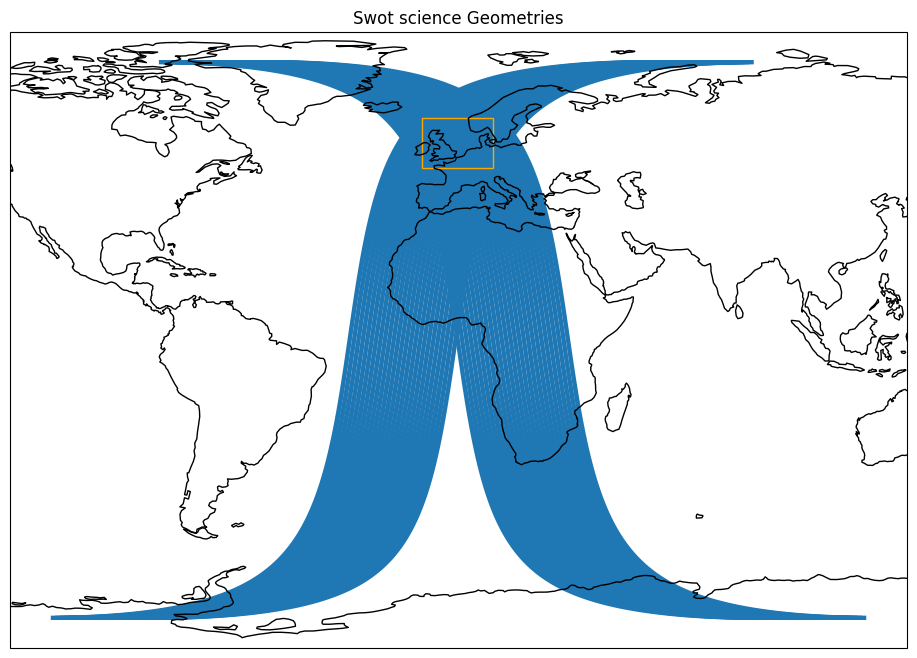

In [22]:
# Define cycles and half_orbits numbers to download
dic = {'calval':np.arange(474,579),
      'science': np.arange(1,34),
      }

# loop over to download both phases.
for phase in dic.keys():
    # select phase
    print(phase) 
    # select cycle numbers
    cycles = dic[phase] 
    # select geometry files
    GEOMETRIES_FILE = path+f'KaRIn_2kms_{phase}_geometries.geojson'     
    # find passes
    swath_geoms = get_half_orbits_intersect(bbox,GEOMETRIES_FILE = GEOMETRIES_FILE)
    # plot passes
    plot_geometries(swath_geoms, lon_range, lat_range, f"Swot {phase} Geometries")
    # save passess numbers
    pass_numbers = list(swath_geoms['pass_number'])
    # download files
    output_dir = path_data+phase+'/full/'
    downloaded_files = ftp_download_files(ftp_path, 
                                          level, variant, cycles, 
                                          pass_numbers, output_dir, only_last=True)

        

### Subset only study region
Note, download function gives you entire swath. Now we clip only region of interest

In [ ]:
for phase in dic.keys():
    print(phase)
    output_dir = path_data+phase+'/full/'
    # set path where we will save subset
    path_data = path+'SLSC/'+phase+'/subset/'
    # list all files in the full directory
    files = [file for file in os.listdir(output_dir) if file.endswith('.nc') and not file.startswith('.')]
    
    cycles = np.unique([file.split('_')[5] for file in files])
    passes = np.unique([file.split('_')[6] for file in files])
    
    for i, file in enumerate(flist):
        print('{}/{}: {}' .format(i,len(flist),file))
        ds = xr.open_dataset(output_dir+file)
        subset_ds(ds,lon_range,lat_range,save=True,
                  output_dir=path_data,
                  filename=file.split('.nc')[0]+'_red'
          )